# Base script for Ocean Parcels to use for sensitivity analysis. 

Author: Johanna Wren

email: johanna.wren@noaa.gov

Date: September 21, 2021

Basic script for use during sensitivity analysis for LAPS modeling. This script advects particles in pre-defined locations at a pre-defined depth using HYCOM currents stored on file. The trajectories are saved as a NetCDF file. This script contains a particle age (PLD) but no land avoidance and uses 2D passive dispersal with diffusivity. 

## Load libraries
Loading all the libraries we need for basic 2D fourth order Runge-Kutta dispersal with diffusion.  

In [12]:
# Load libraries etc.
from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, plotTrajectoriesFile, Variable, ParcelsRandom, Field, AdvectionRK4, DiffusionUniformKh
import numpy as np
import pandas as pd
#import xarray as xr
from datetime import timedelta, datetime
import math

## Define custom kenels
This is where we define other useful custom kenels.

### DELETE PARTICLES
`DeleteParticles` allows for particles to be deleted when they exit the dispersal domain. This is applied to the borders of the domain but NOT to land. 

*NOTE: When currents are loaded into the fieldset the missing values over land get converted to zeros so particles that hit land just stop there and bunch up. This shouldn't be a problem for this application, but if it is, we can add land avoidance kernels.*  

In [13]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

### AGEING
The `Ageing` kernel removes particles after a specific time period (PLD) by calling the `DeleteParticles` kernel. This allows you to run simulation for long periods of time while removing particles after a set number of days. We read in the PLD as a constant in the fieldset and this kernel grabs the PLD value from there. 

In [14]:
def Ageing(particle, fieldset, time):
    particle.age += particle.dt
    if particle.age >= fieldset.pld:
        particle.delete()

## Create a fieldset
We are creating a fieldset from HYCOM current files downloaded and stored on a drive. The fieldset is what OceanParcels uses to store all the information it needs for the flowfield that it moves particles through.

The HYCOM data was downloaded using the `HYCOM_download_sensitivity.jnl` script and grabs u and v currents for a region 120E-120W and 0-50N for the top 50 meters (15 layers of the model). The files are saved as HYCOM_LAPS_Sensitivity_????.nc where the number indexing is days since the start of the dataseries on Jan 1, 1994. The HYCOM data can be found on the [APDRC website](http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_6a0a_5127_d118). 

Because these files were saved using Ferret the lon and lat variable names are a bit different but it shouldn't change anything practically. You can always check the variable names by reading them R using the `ncdf4` package or through `ncdump -h HYCOM_LAPS_Sensitivity_7117.nc` command in your terminal (on a unix/linux machine). 

When you generate the fieldset, don't forget to <span style="color:red">**set your dept variable here to whichever depth strata you want to use.**</span>



In [15]:
filename = "LAPS_HYCOMfiles/HYCOM_LAPS_Sensitivity_*.nc"
variables = {'U': 'WATER_U',
             'V': 'WATER_V'}
dimensions = {'lat': 'LATITUDE1501_2251',
              'lon': 'LONGITUDE3751_5251',
              'depth': 'LEV1_15',
              'time': 'TIME'}
fieldset = FieldSet.from_netcdf(filename, variables, dimensions)

Run some diagnostics on the `fieldset` to make sure it is read in properly. If your dataset is straddeling the 180 longitude, Parcels might plot the map in +-180 so the fieldset isn't continuous geographically, but that is just the plotting function, it still works fine and advects across the 180 meridian. 

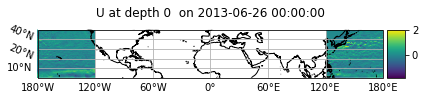

In [16]:
# Plot the U field
fieldset.U.show()

## Add diffusivity
In order for diffusivity to be incorporated we need to add zonal and meridional Kh fields. This code uses spatially homogenous diffusivity, but if you want spatially varying diffusivity use the `AdvectionDiffusionEM` or `AdvectionDiffusionM1` kernel instead.

Skip the next cell if you want to run without diffusivity. 

In [17]:
kh = 10   # This is the eddy diffusivity in m2/s

# Add even diffusivity to the fieldset
fieldset.add_constant_field('Kh_zonal', kh, mesh='spherical')
fieldset.add_constant_field('Kh_meridional', kh, mesh='spherical')            

## Add PLD
Here we add the PLD as a constant to te fieldset. If you want to change up the PLD all you have to do is change the number here.

In [18]:
# Add PLD to fieldset
pld = 180   # in days
fieldset.add_constant('pld', (pld*86400))

## Define your particle type
We are using a JIT particle but we are adding the age variable along with a release site variable. These variables will print to the output file, but it's easy to change to not show in the ouput file. 

The release site is just a number for the island the particle was released from and makes it much easier when we construct connectivity matrices in post processing. The island values are listed in a separate column in your LAPS_release_sites.csv file. 

In [19]:
class AgeingParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0.)
    releaseSite = Variable('releaseSite', dtype=np.int32)

## Set particle release locations
Next, we instantiate a `ParticeSet` composed of `JITParticle`. 

`ParticleSet` holds release locations, the number of particles released, the release depth, and how often a particel should be released (daily, every 6h, etc.)

Particles are released from locations specified in a file. We use this if we want to release at for example all reef locations in the islands, or any other list of locations. If we are releaseing multiple particles for each site we need to repeat them with the dates and depths and that is what we are doing with the `np.repeat` part. 

You can add or omit `pdepth`, `time` and `repeatdt` for a one time release at the default `fieldset` depth (in a multi depth file default is top layer) and time. 

In [20]:
# Set input file
infile = pd.read_csv('LAPS_release_sites_noHI.csv')

# Set number of particles you want to release
npart = 100

# Set the release depth
depth = 5

# Make vectors that repeat the release site and dept npart number of times
habilon = np.repeat(infile.Lon, npart)
habilat = np.repeat(infile.Lat, npart)
habisite = np.repeat(infile.Site, npart)
habidepth = np.repeat(depth, len(habilon))

# Time interval between particle release (in seconds)
release_int = 86400

# Start date for release (if you want it different from the first day of the currents in the fielset)
start_date = datetime(2013, 1, 1)

# Define the pset
pset = ParticleSet.from_list(fieldset=fieldset, 
                             pclass=AgeingParticle, 
                             lon=habilon,
                             lat=habilat,
                             depth=habidepth,
                             releaseSite=habisite,
                             repeatdt=release_int)

### Visualize particle start locations
We can now see where the particles are seesed by using `pset.show` 

**If you are releasing a lot of particles the pset will be very long so you might want to skip printing it.**

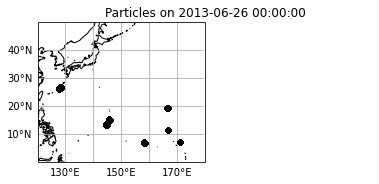

In [23]:
#print(pset)
pset.show()

## Advect particles

To invoke the custom kernels we wrote earlier we need to combine them into a format Parcels can use. Simply string all the kernels together that you want to use.


In [22]:
# Combine kernels you are using
kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(DiffusionUniformKh) + pset.Kernel(Ageing)

Execute the advection. Depending on how many particles you release and the length of your release this may take some time. 

Particles specified in `ParticleSet` are advected using `kernels` at a `model_dt` time step and printed in a netcdf file (`outfile`) at `save_dt` time steps. Particels reaching the limits of the domain are removed through `recovery`. 

The naming convention for the output file is  LAPS\_n[number of particles released at each site]\_pld[pld in days]\_[depth layer]m\_Kh[diffusivity]\_nday[length of run in days]_\[start date of simulation in format MMDDYYYY].nc e.g. LAPS_sensitivity_n100_180pld_5m_Kh10_nday365_06262013.nc

In [ ]:
# Time step in model
model_dt = timedelta(hours=3)

# Time step to save to file
save_dt = timedelta(days=1)

# Length of model run
run_days = 365  # how long you want to realease particles for

# Set output file name
output_file = pset.ParticleFile(name="Test_LAPS_sensitivity_n100_180pld_5m_Kh10_nday365_06262013.nc", outputdt=save_dt)

# Execute and release daily during this timeframe
pset.execute(kernels,
            runtime=timedelta(days=run_days),
            dt=model_dt, 
            recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
            output_file=output_file)

INFO: Compiled ArrayAgeingParticleAdvectionRK4DiffusionUniformKhAgeing ==> /var/folders/6z/7snm9z7n1t1f5xnq500m7z_js00kn8/T/parcels-1912621736/lib44424d6b2fe880693efbe4ff9a5d94fc_0.so
INFO: Temporary output files are stored in out-GLQCBJPH.
INFO: You can use "parcels_convert_npydir_to_netcdf out-GLQCBJPH" to convert these to a NetCDF file during the run.
 55% (17625600.0 of 31536000.0) |####    | Elapsed Time: 0:13:45 ETA:   0:17:20

To make sure particles have been advected run `pset.show()` again. 

In [ ]:
pset.show()

## Visualize the dispersal

### Plot trajectories
Plot the trajectories saved to the netcdf file `outfile` on a map. It's not going to be pretty, but it gives you an idea if the dispersal made sense or not. 

**If you have a lot of trajectories this will take a long time. You are better off plotting them using straigt up Python methods, in R, or any other prefered software.**

In [ ]:
#plotTrajectoriesFile(outfile)